In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt

# Mostrar gráficos inline si estás en Jupyter
%matplotlib inline

# ==========================
# CONFIG
# ==========================

DATASETS = ["emails_es", "emails_en"]
EXPERIMENTS = ["rag_vt5", "rag_vt5_qwen"]

# Nombres esperados de los CSV generados por multi_eval.py:
results_{dataset}_{exp}.csv 
#
# Si además corres DUDU sobre esos mismos CSV y guardas en:
#   results_{dataset}_{exp}_dudu.csv
# este notebook intentará leer también E, C, H, DUDU_score.


In [2]:
# ==========================
# HELPERS
# ==========================

def safe_mean(series):
    """Media segura (ignora NaN y listas vacías)."""
    if series is None or len(series) == 0:
        return float("nan")
    return float(series.mean())


def load_results_for(dataset, exp):
    """
    Carga:
    - results_{dataset}_{exp}.csv  (ANLS, retrieval, chunk_score, etc.)
    - opcionalmente results_{dataset}_{exp}_dudu.csv  (E,C,H,DUDU_score)
    Devuelve un DataFrame combinado.
    """
    base_name = f"results_{dataset}_{exp}.csv"
    dudu_name = f"results_{dataset}_{exp}_dudu.csv"

    if not os.path.exists(base_name):
        print(f"⚠️ No encontrado: {base_name}")
        return None

    df = pd.read_csv(base_name)

    # Intentar cargar DUDU
    if os.path.exists(dudu_name):
        print(f"➡️ Encontrado DUDU para {dataset}/{exp}: {dudu_name}")
        df_dudu = pd.read_csv(dudu_name)
        # Unimos por 'question' si existe; si no, por índice
        if "question" in df.columns and "question" in df_dudu.columns:
            df = df.merge(
                df_dudu[["question", "E", "C", "H", "DUDU_score"]],
                on="question",
                how="left",
                suffixes=("", "_dudu"),
            )
        else:
            # join por índice
            df = pd.concat(
                [df, df_dudu[["E", "C", "H", "DUDU_score"]]],
                axis=1
            )
    else:
        print(f"ℹ️ No hay archivo DUDU para {dataset}/{exp} ({dudu_name})")

    return df


In [3]:
# ==========================
# MAIN: construir tabla resumen
# ==========================

from IPython.display import display

def build_summary_table():
    summary_rows = []
    os.makedirs("plots", exist_ok=True)

    for ds in DATASETS:
        for exp in EXPERIMENTS:
            df = load_results_for(ds, exp)
            if df is None:
                continue

            # Métricas clásicas
            avg_anls = safe_mean(df["anls"]) if "anls" in df.columns else float("nan")
            avg_ret = safe_mean(df["retrieval_precision@k"]) if "retrieval_precision@k" in df.columns else float("nan")
            avg_chunk = safe_mean(df["chunk_score@k"]) if "chunk_score@k" in df.columns else float("nan")

            # ANLS solo VT5 (para ver cuánto mejora con Qwen)
            avg_vt5_anls = safe_mean(df["vt5_anls"]) if "vt5_anls" in df.columns else float("nan")

            # DUDU (si existe)
            avg_E = safe_mean(df["E"]) if "E" in df.columns else float("nan")
            avg_C = safe_mean(df["C"]) if "C" in df.columns else float("nan")
            avg_H = safe_mean(df["H"]) if "H" in df.columns else float("nan")
            avg_dudu = safe_mean(df["DUDU_score"]) if "DUDU_score" in df.columns else float("nan")

            summary_rows.append(
                {
                    "dataset": ds,
                    "experiment": exp,
                    "avg_anls": avg_anls,
                    "avg_vt5_anls": avg_vt5_anls,
                    "avg_ret@k": avg_ret,
                    "avg_chunk_score@k": avg_chunk,
                    "avg_E": avg_E,
                    "avg_C": avg_C,
                    "avg_H": avg_H,
                    "avg_DUDU": avg_dudu,
                }
            )

    if not summary_rows:
        print("⚠️ No se encontró ningún CSV de resultados. ¿Ya corriste multi_eval?")
        return None

    summary_df = pd.DataFrame(summary_rows)

    # Mostrar tabla en el notebook
    display(summary_df.style.format(precision=3))

    # Guardar la tabla para usarla en el paper o en otros scripts
    summary_df.to_csv("multi_eval_summary.csv", index=False, encoding="utf-8")
    print("💾 Tabla resumen guardada en multi_eval_summary.csv")

    return summary_df


In [4]:
def plot_metrics(summary_df):
    """Genera las gráficas de ANLS, DUDU, y un scatter ANLS vs DUDU (demo)."""
    os.makedirs("plots", exist_ok=True)

    # 1) Barras: ANLS por dataset/experimento
    for ds in DATASETS:
        sub = summary_df[summary_df["dataset"] == ds]
        if sub.empty:
            continue

        plt.figure()
        plt.title(f"ANLS promedio por experimento – {ds}")
        plt.bar(sub["experiment"], sub["avg_anls"])
        plt.ylabel("ANLS")
        plt.ylim(0, 1.0)
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"plots/anls_{ds}.png")
        plt.show()

    # 2) Barras: DUDU_score promedio (si hay)
    if not summary_df["avg_DUDU"].isna().all():
        for ds in DATASETS:
            sub = summary_df[summary_df["dataset"] == ds]
            if sub.empty:
                continue

            if sub["avg_DUDU"].isna().all():
                continue

            plt.figure()
            plt.title(f"DUDU_score promedio por experimento – {ds}")
            plt.bar(sub["experiment"], sub["avg_DUDU"])
            plt.ylabel("DUDU_score (0–1)")
            plt.ylim(0, 1.0)
            plt.grid(axis="y", alpha=0.3)
            plt.tight_layout()
            plt.savefig(f"plots/dudu_{ds}.png")
            plt.show()

    # 3) Scatter ANLS vs DUDU por ejemplo (solo para un caso como demo)
    demo_ds = "emails_es"
    demo_exp = "rag_vt5_qwen"
    demo_path = f"results_{demo_ds}_{demo_exp}_dudu.csv"
    if os.path.exists(demo_path):
        df_demo = pd.read_csv(demo_path)
        if "anls" in df_demo.columns and "DUDU_score" in df_demo.columns:
            plt.figure()
            plt.title(f"ANLS vs DUDU_score – {demo_ds}/{demo_exp}")
            plt.scatter(df_demo["anls"], df_demo["DUDU_score"])
            plt.xlabel("ANLS")
            plt.ylabel("DUDU_score")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.savefig("plots/scatter_anls_vs_dudu_emails_es_rag_vt5_qwen.png")
            plt.show()
            print("📈 Scatter ANLS vs DUDU guardado en plots/scatter_anls_vs_dudu_emails_es_rag_vt5_qwen.png")
        else:
            print(f"⚠️ {demo_path} no tiene columnas 'anls' y 'DUDU_score' juntas.")
    else:
        print(f"ℹ️ No se encontró {demo_path} para el scatter ANLS vs DUDU.")


ANLS promedio por experimento – emails_es

Qué muestra:
Barras para ANLS en español:

rag_vt5 ≈ 0.23

rag_vt5_qwen ≈ 0.37

Lectura:

Al meter Qwen encima de VT5, el ANLS sube ~0.14 puntos (≈ +60% relativo).

Esto significa que en el dataset español, Qwen ayuda al generador a producir respuestas más cercanas al texto de referencia.

Mensaje que puedes decir:

“En español, el híbrido RAG + Qwen corrige muchas respuestas que VT5 solo fallaba; ANLS mejora de 0.23 a 0.37.”

ANLS promedio por experimento – emails_en

Qué muestra:
Barras para ANLS en inglés:

rag_vt5 ≈ 0.49

rag_vt5_qwen ≈ 0.42

Lectura:

Aquí pasa al revés: ANLS baja un poco al activar Qwen.

O sea, VT5 ya lo hacía relativamente bien en inglés y, cuando Qwen re-formula, a veces se aleja de la cadena exacta de la ground truth.

Interpretación conceptual:

ANLS castiga más el paráfrasis (si dices lo mismo con palabras muy distintas) que un LLM-judge.

Por eso, aunque semánticamente Qwen puede estar bien, ANLS lo mira como “más lejos”.

DUDU_score promedio – emails_es

Qué muestra:
DUDU promedio español:

rag_vt5 ≈ 0.39

rag_vt5_qwen ≈ 0.84

Lectura:

El salto es brutal: más del doble.

DUDU combina E, C, H (exactitud, cobertura, alucinación).

El juez LLM percibe que con Qwen:

Las respuestas son más exactas,

Cubren mejor la información relevante,

Y alucinan menos respecto al contexto.

Mensaje fuerte:

“Aunque ANLS sube ‘solo’ de 0.23 a 0.37, desde la perspectiva de un juez LLM (DUDU), la calidad percibida se multiplica por dos en español.”

➡️ Encontrado DUDU para emails_es/rag_vt5: results_emails_es_rag_vt5_dudu.csv
➡️ Encontrado DUDU para emails_es/rag_vt5_qwen: results_emails_es_rag_vt5_qwen_dudu.csv
➡️ Encontrado DUDU para emails_en/rag_vt5: results_emails_en_rag_vt5_dudu.csv
➡️ Encontrado DUDU para emails_en/rag_vt5_qwen: results_emails_en_rag_vt5_qwen_dudu.csv


,dataset,experiment,avg_anls,avg_vt5_anls,avg_ret@k,avg_chunk_score@k,avg_E,avg_C,avg_H,avg_DUDU
0,emails_es,rag_vt5,0.229,0.229,1.000,0.861,1.133,1.133,1.333,0.391
1,emails_es,rag_vt5_qwen,0.365,0.229,1.000,0.861,2.467,2.467,2.800,0.844
2,emails_en,rag_vt5,0.488,0.488,0.867,0.851,2.400,2.267,2.800,0.813
3,emails_en,rag_vt5_qwen,0.422,0.488,0.867,0.851,2.733,2.667,2.933,0.918


💾 Tabla resumen guardada en multi_eval_summary.csv


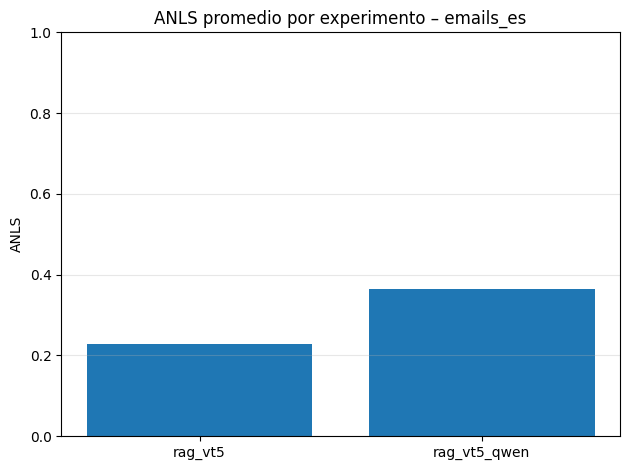

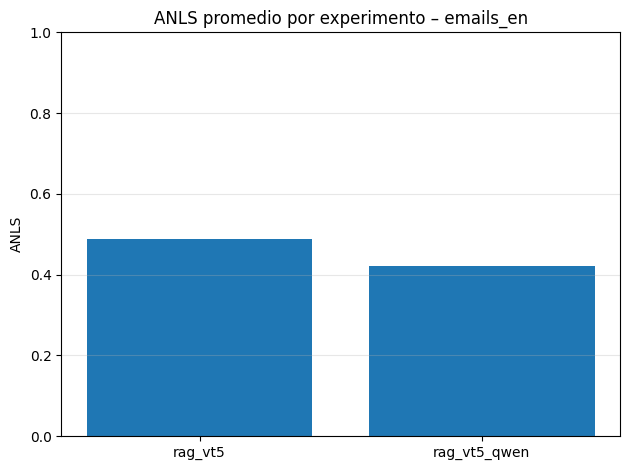

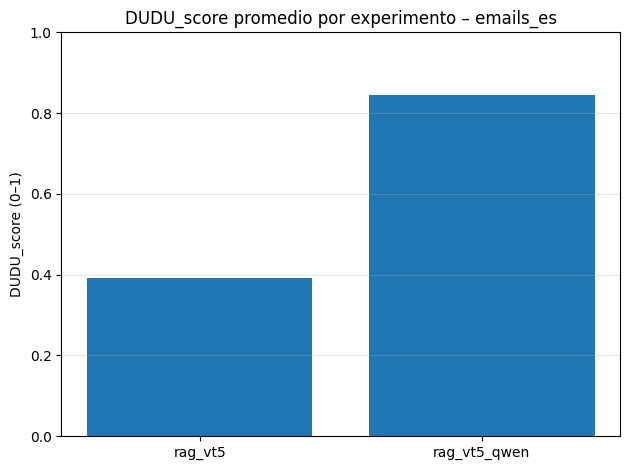

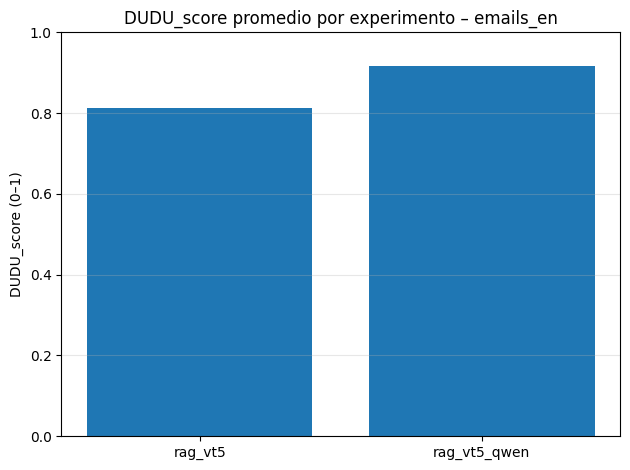

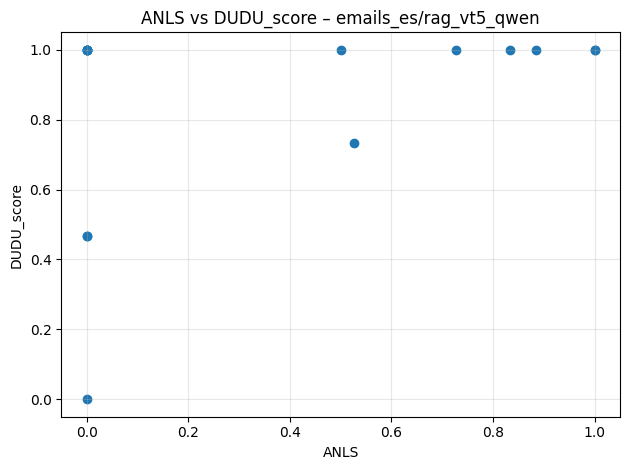

📈 Scatter ANLS vs DUDU guardado en plots/scatter_anls_vs_dudu_emails_es_rag_vt5_qwen.png


In [5]:
# Ejecutar todo: construir tabla y graficar
summary_df = build_summary_table()
if summary_df is not None:
    plot_metrics(summary_df)


# EDA

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el resumen
df = pd.read_csv("multi_eval_summary.csv")

# Ver la tabla redondeada
df_round = df.copy()
for col in df_round.columns:
    if df_round[col].dtype == "float64":
        df_round[col] = df_round[col].round(3)

df_round


,dataset,experiment,avg_anls,avg_vt5_anls,avg_ret@k,avg_chunk_score@k,avg_E,avg_C,avg_H,avg_DUDU
0,emails_es,rag_vt5,0.229,0.229,1.000,0.861,1.133,1.133,1.333,0.391
1,emails_es,rag_vt5_qwen,0.365,0.229,1.000,0.861,2.467,2.467,2.800,0.844
2,emails_en,rag_vt5,0.488,0.488,0.867,0.851,2.400,2.267,2.800,0.813
3,emails_en,rag_vt5_qwen,0.422,0.488,0.867,0.851,2.733,2.667,2.933,0.918


In [9]:
# Reorganizar para comparar rag_vt5 vs rag_vt5_qwen por dataset
base = df[df["experiment"] == "rag_vt5"].set_index("dataset")
qwen = df[df["experiment"] == "rag_vt5_qwen"].set_index("dataset")

delta = qwen[["avg_anls", "avg_E", "avg_DUDU"]] - base[["avg_anls", "avg_E", "avg_DUDU"]]
delta = delta.rename(
    columns={
        "avg_anls": "Δ ANLS (Qwen - VT5)",
        "avg_E": "Δ E (Qwen - VT5)",
        "avg_DUDU": "Δ DUDU (Qwen - VT5)",
    }
)

delta.round(3)


,Δ ANLS (Qwen - VT5),Δ E (Qwen - VT5),Δ DUDU (Qwen - VT5)
dataset,,,
emails_es,0.136,1.333,0.453
emails_en,-0.066,0.333,0.104


# 1 USAR

ANLS por dataset y experimento (barras agrupadas)

Qué muestra:
Eje x = dataset (emails_es, emails_en),
Dos barras por grupo: rag_vt5 y rag_vt5_qwen.

Lectura:

En español: ANLS sube bastante con Qwen.

En inglés: ANLS baja un poco con Qwen.

Por qué es importante:

Es la figura más compacta para comparar efecto de Qwen x idioma.

Dice: “Qwen compensa más en el idioma donde el baseline es más débil (español)”.

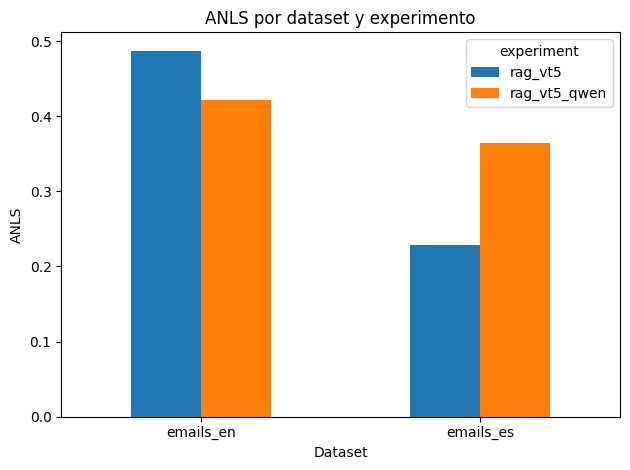

In [10]:
# Gráfica de ANLS por dataset / experimento
metric = "avg_anls"

pivot_anls = df.pivot(index="dataset", columns="experiment", values=metric)

ax = pivot_anls.plot(kind="bar")
ax.set_title("ANLS por dataset y experimento")
ax.set_ylabel("ANLS")
ax.set_xlabel("Dataset")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# 2 USAR

DUDU promedio por dataset y experimento (barras agrupadas)

Qué muestra:
Igual que G6 pero con DUDU.

Lectura:

En ambos idiomas los experimentos con Qwen (rag_vt5_qwen) están claramente por encima.

En español la mejora es MUY grande; en inglés es moderada pero consistente.

Mensaje fuerte:

“Independientemente del idioma, el esquema híbrido con Qwen produce respuestas que un LLM-judge percibe como más correctas, completas y bien fundamentadas.”

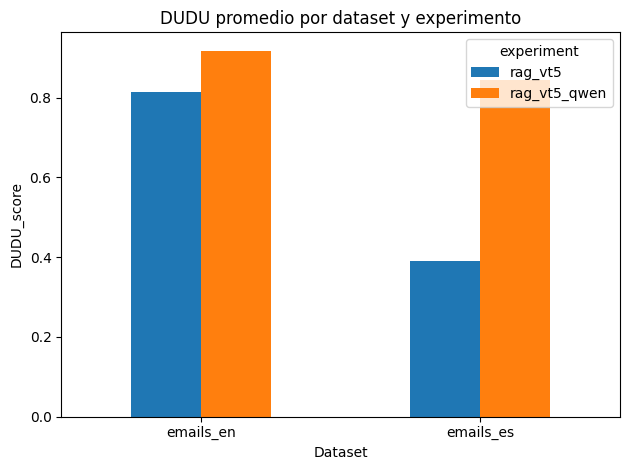

In [11]:
# Gráfica de DUDU por dataset / experimento
metric = "avg_DUDU"

pivot_dudu = df.pivot(index="dataset", columns="experiment", values=metric)

ax = pivot_dudu.plot(kind="bar")
ax.set_title("DUDU promedio por dataset y experimento")
ax.set_ylabel("DUDU_score")
ax.set_xlabel("Dataset")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [12]:
# Promedios globales E, C, H por experimento (promediando datasets)
agg_ech = (
    df.groupby("experiment")[["avg_E", "avg_C", "avg_H"]]
    .mean()
    .reset_index()
)

agg_ech_round = agg_ech.copy()
for col in ["avg_E", "avg_C", "avg_H"]:
    agg_ech_round[col] = agg_ech_round[col].round(3)

agg_ech_round


,experiment,avg_E,avg_C,avg_H
0,rag_vt5,1.767,1.700,2.067
1,rag_vt5_qwen,2.600,2.567,2.867


# 3 USAR 

Scatter “Relación ANLS vs DUDU (promedios por experimento)”

Qué muestra:
Cada punto = (ANLS promedio, DUDU promedio) de un experimento en un dataset:

emails_es / rag_vt5

emails_es / rag_vt5_qwen

emails_en / rag_vt5

emails_en / rag_vt5_qwen

Lectura:

Muestra que no hay una relación lineal perfecta:

emails_en/rag_vt5 tiene ANLS alto pero DUDU algo más bajo que emails_en/rag_vt5_qwen.

emails_es/rag_vt5_qwen tiene más ANLS y muchísimo más DUDU que emails_es/rag_vt5.

Uso en el texto:

Sirve para argumentar que ANLS y DUDU son complementarias:

ANLS captura qué tanto te acercas al texto exacto;

DUDU captura cómo se ve la respuesta desde un juez semántico.

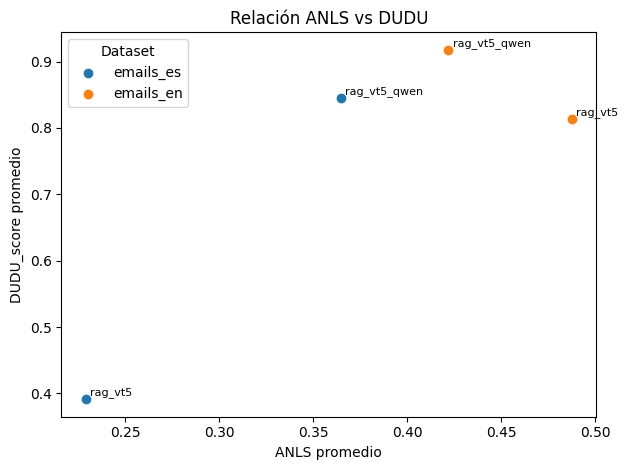

In [13]:
fig, ax = plt.subplots()

for ds in df["dataset"].unique():
    subset = df[df["dataset"] == ds]
    ax.scatter(
        subset["avg_anls"],
        subset["avg_DUDU"],
        label=ds,
    )
    # Etiqueta con el nombre del experimento cerca del punto
    for _, row in subset.iterrows():
        ax.annotate(
            row["experiment"],
            (row["avg_anls"], row["avg_DUDU"]),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=8,
        )

ax.set_title("Relación ANLS vs DUDU")
ax.set_xlabel("ANLS promedio")
ax.set_ylabel("DUDU_score promedio")
ax.legend(title="Dataset")
plt.tight_layout()
plt.show()


# 4 USAR 

Ganancia absoluta de Qwen vs VT5 por dataset” (Δ ANLS, Δ E, Δ DUDU)

Qué muestra:
Para cada dataset, barras que representan:

Δ ANLS = ANLS(Qwen) – ANLS(VT5),

Δ E, Δ DUDU (Qwen – VT5).

Lectura:

emails_es:

Δ ANLS > 0 (mejora),

Δ E muy grande,

Δ DUDU considerable.

emails_en:

Δ ANLS ligeramente < 0,

pero Δ E y Δ DUDU > 0 (especialmente Δ E).

Por qué es buenísima:

Habla en términos de ganancia, que es como suelen presentar resultados en papers (“Qwen aporta +X puntos en...”).

Muestra que:

En español el beneficio es integral (lexical y semántico).

En inglés el beneficio es sobre todo semántico (juez ve mejor calidad aunque ANLS baje).

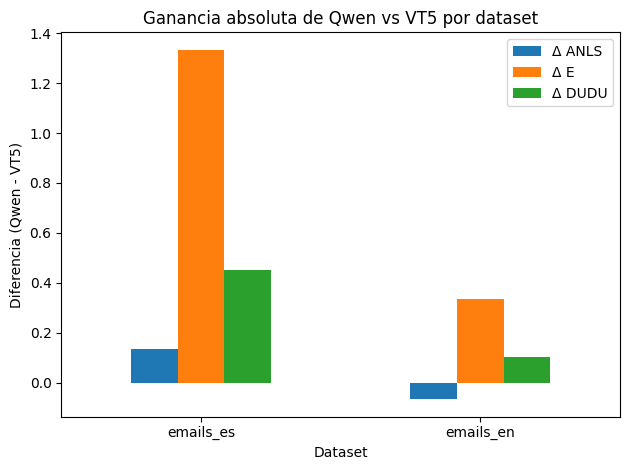

,Δ ANLS,Δ E,Δ DUDU
dataset,,,
emails_es,0.136,1.333,0.453
emails_en,-0.066,0.333,0.104


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("multi_eval_summary.csv")

base = df[df["experiment"] == "rag_vt5"].set_index("dataset")
qwen = df[df["experiment"] == "rag_vt5_qwen"].set_index("dataset")

delta = qwen[["avg_anls", "avg_E", "avg_DUDU"]] - base[["avg_anls", "avg_E", "avg_DUDU"]]
delta = delta.rename(
    columns={
        "avg_anls": "Δ ANLS",
        "avg_E": "Δ E",
        "avg_DUDU": "Δ DUDU",
    }
)

ax = delta.plot(kind="bar")
ax.set_title("Ganancia absoluta de Qwen vs VT5 por dataset")
ax.set_ylabel("Diferencia (Qwen - VT5)")
ax.set_xlabel("Dataset")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

delta.round(3)


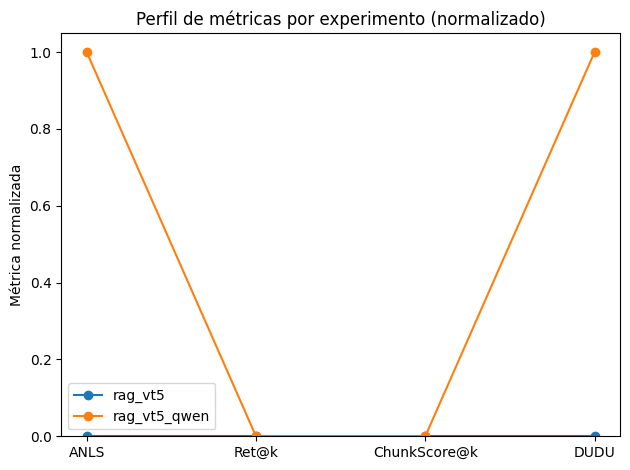

,avg_anls,avg_ret@k,avg_chunk_score@k,avg_DUDU
experiment,,,,
rag_vt5,0.0,0.0,0.0,0.0
rag_vt5_qwen,1.0,0.0,0.0,1.0


In [15]:
import numpy as np

# Elegimos métricas comparables y las normalizamos en [0,1] aprox
metrics = ["avg_anls", "avg_ret@k", "avg_chunk_score@k", "avg_DUDU"]
labels = ["ANLS", "Ret@k", "ChunkScore@k", "DUDU"]

agg = df.groupby("experiment")[metrics].mean()

# Normalizar por columna
norm = (agg - agg.min()) / (agg.max() - agg.min() + 1e-8)

x = np.arange(len(labels))

fig, ax = plt.subplots()
for exp in norm.index:
    ax.plot(x, norm.loc[exp, :], marker="o", label=exp)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Métrica normalizada")
ax.set_title("Perfil de métricas por experimento (normalizado)")
ax.legend()
plt.tight_layout()
plt.show()

norm.round(3)


/tmp/ipykernel_323573/768625699.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


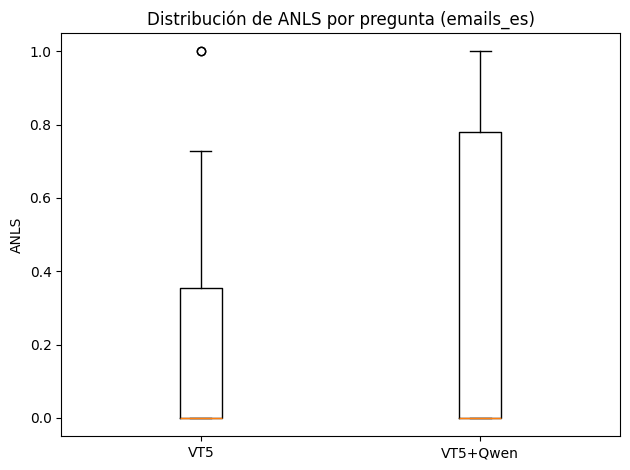

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta de tus archivos (ajusta si cambia el nombre)
csv_es_vt5  = "results_emails_es_rag_vt5.csv"
csv_es_qwen = "results_emails_es_rag_vt5_qwen.csv"

df_es_vt5  = pd.read_csv(csv_es_vt5)
df_es_qwen = pd.read_csv(csv_es_qwen)

anls_es_vt5  = df_es_vt5["anls"]
anls_es_qwen = df_es_qwen["anls"]

fig, ax = plt.subplots()
ax.boxplot(
    [anls_es_vt5, anls_es_qwen],
    labels=["VT5", "VT5+Qwen"],
)
ax.set_title("Distribución de ANLS por pregunta (emails_es)")
ax.set_ylabel("ANLS")
plt.tight_layout()
plt.show()


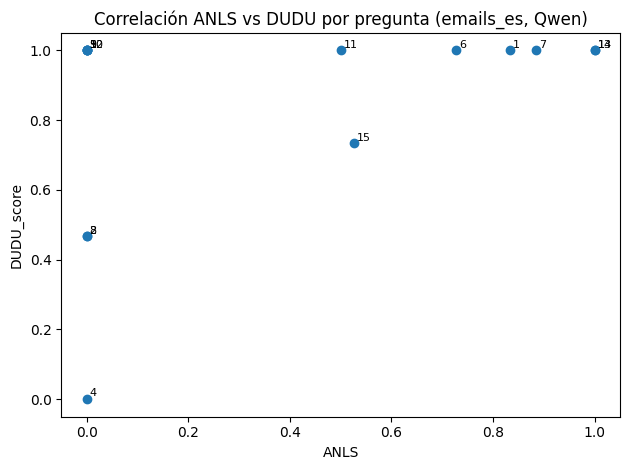

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Ajusta nombres de archivo según cómo los guardaste
csv_dudu_es_qwen = "results_emails_es_rag_vt5_qwen_dudu.csv"

df_dudu = pd.read_csv(csv_dudu_es_qwen)

# Convertir a float por si vienen como string
df_dudu["anls"] = df_dudu["anls"].astype(float)
df_dudu["DUDU_score"] = df_dudu["DUDU_score"].astype(float)

fig, ax = plt.subplots()
ax.scatter(df_dudu["anls"], df_dudu["DUDU_score"])

for i, row in df_dudu.iterrows():
    ax.annotate(
        str(i+1),
        (row["anls"], row["DUDU_score"]),
        xytext=(2, 2),
        textcoords="offset points",
        fontsize=8,
    )

ax.set_title("Correlación ANLS vs DUDU por pregunta (emails_es, Qwen)")
ax.set_xlabel("ANLS")
ax.set_ylabel("DUDU_score")
plt.tight_layout()
plt.show()


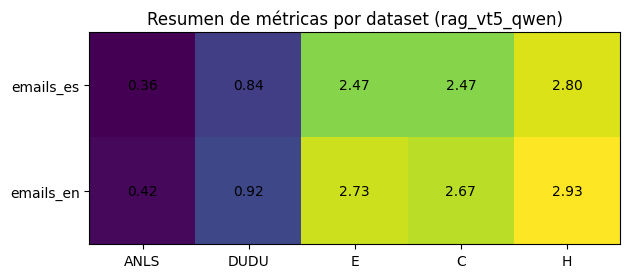

In [18]:
import numpy as np

metrics = ["avg_anls", "avg_DUDU", "avg_E", "avg_C", "avg_H"]
labels = ["ANLS", "DUDU", "E", "C", "H"]

# Promediar por dataset (mezclando experimentos o escoger solo rag_vt5_qwen)
df_qwen = df[df["experiment"] == "rag_vt5_qwen"].set_index("dataset")

data = df_qwen[metrics].values
datasets = df_qwen.index.tolist()

fig, ax = plt.subplots()
im = ax.imshow(data)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(datasets)))
ax.set_yticklabels(datasets)

for i in range(len(datasets)):
    for j in range(len(labels)):
        ax.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center")

ax.set_title("Resumen de métricas por dataset (rag_vt5_qwen)")
plt.tight_layout()
plt.show()


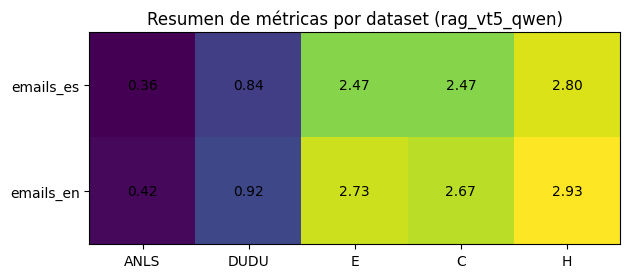

In [19]:
import numpy as np

metrics = ["avg_anls", "avg_DUDU", "avg_E", "avg_C", "avg_H"]
labels = ["ANLS", "DUDU", "E", "C", "H"]

# Promediar por dataset (mezclando experimentos o escoger solo rag_vt5_qwen)
df_qwen = df[df["experiment"] == "rag_vt5_qwen"].set_index("dataset")

data = df_qwen[metrics].values
datasets = df_qwen.index.tolist()

fig, ax = plt.subplots()
im = ax.imshow(data)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(datasets)))
ax.set_yticklabels(datasets)

for i in range(len(datasets)):
    for j in range(len(labels)):
        ax.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center")

ax.set_title("Resumen de métricas por dataset (rag_vt5_qwen)")
plt.tight_layout()
plt.show()


# DUDU AS SCHEME

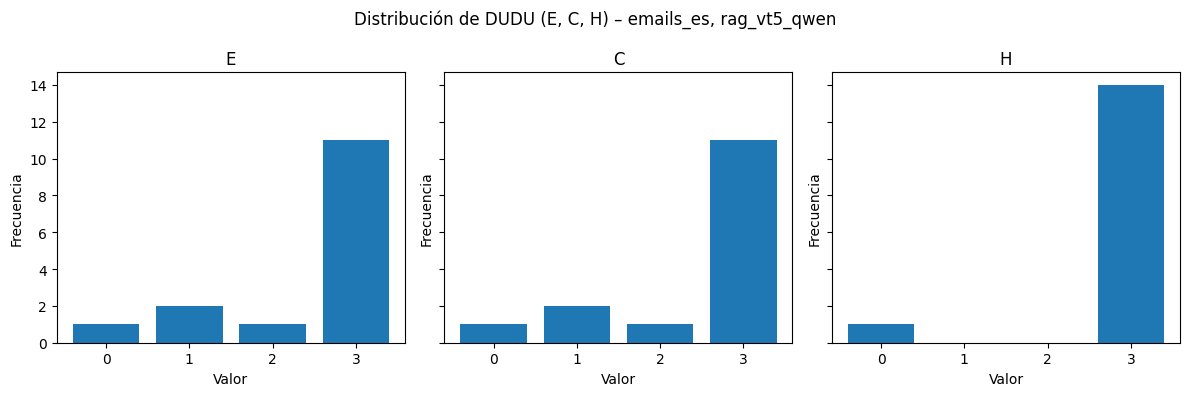

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Cambia por el archivo que quieras analizar
csv_path = "results_emails_es_rag_vt5_qwen_dudu.csv"

df_dudu = pd.read_csv(csv_path)

# Asegúrate de que sean int
for col in ["E", "C", "H"]:
    df_dudu[col] = pd.to_numeric(df_dudu[col], errors="coerce").fillna(0).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ax, col in zip(axes, ["E", "C", "H"]):
    counts = df_dudu[col].value_counts().sort_index()  # 0..3
    ax.bar(counts.index, counts.values)
    ax.set_title(col)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xlabel("Valor")
    ax.set_ylabel("Frecuencia")

fig.suptitle("Distribución de DUDU (E, C, H) – emails_es, rag_vt5_qwen")
plt.tight_layout()
plt.show()


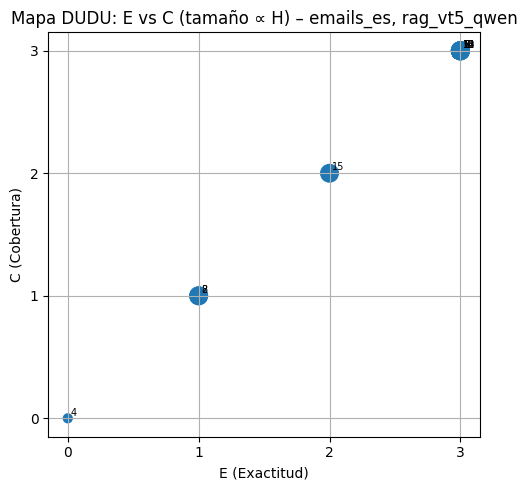

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "results_emails_es_rag_vt5_qwen_dudu.csv"
df_dudu = pd.read_csv(csv_path)

for col in ["E", "C", "H"]:
    df_dudu[col] = pd.to_numeric(df_dudu[col], errors="coerce").fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(5, 5))

# Tamaño del punto ~ (H+1), para ver más grande cuando hay más hallucination
sizes = (df_dudu["H"] + 1) * 40

ax.scatter(df_dudu["E"], df_dudu["C"], s=sizes)

for i, row in df_dudu.iterrows():
    ax.annotate(
        str(i + 1),
        (row["E"], row["C"]),
        xytext=(2, 2),
        textcoords="offset points",
        fontsize=7,
    )

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xlabel("E (Exactitud)")
ax.set_ylabel("C (Cobertura)")
ax.set_title("Mapa DUDU: E vs C (tamaño ∝ H) – emails_es, rag_vt5_qwen")
plt.grid(True)
plt.tight_layout()
plt.show()


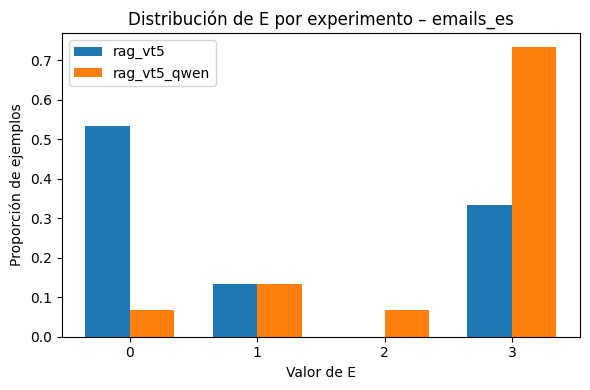

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

files = {
    ("emails_es", "rag_vt5"): "results_emails_es_rag_vt5_dudu.csv",
    ("emails_es", "rag_vt5_qwen"): "results_emails_es_rag_vt5_qwen_dudu.csv",
}

records = []
for (dataset, exp), path in files.items():
    df = pd.read_csv(path)
    for col in ["E", "C", "H"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
        counts = df[col].value_counts().sort_index()
        total = len(df)
        for val in range(4):  # 0..3
            freq = counts.get(val, 0)
            records.append(
                {
                    "dataset": dataset,
                    "experiment": exp,
                    "dim": col,
                    "value": val,
                    "count": freq,
                    "ratio": freq / total,
                }
            )

dist_df = pd.DataFrame(records)

# Ejemplo: comparar distribución de E entre VT5 y VT5+Qwen en emails_es
subset = dist_df[
    (dist_df["dataset"] == "emails_es") &
    (dist_df["dim"] == "E")
].copy()

fig, ax = plt.subplots(figsize=(6, 4))

x = np.arange(4)  # valores 0..3
width = 0.35

for i, exp in enumerate(sorted(subset["experiment"].unique())):
    sub_exp = subset[subset["experiment"] == exp].sort_values("value")
    ax.bar(
        x + i * width,
        sub_exp["ratio"].values,
        width=width,
        label=exp,
    )

ax.set_xticks(x + width / 2)
ax.set_xticklabels([0, 1, 2, 3])
ax.set_xlabel("Valor de E")
ax.set_ylabel("Proporción de ejemplos")
ax.set_title("Distribución de E por experimento – emails_es")
ax.legend()
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

csv_path = "results_emails_es_rag_vt5_qwen_dudu.csv"
df_dudu = pd.read_csv(csv_path)

for col in ["E", "C", "H", "DUDU_score"]:
    df_dudu[col] = pd.to_numeric(df_dudu[col], errors="coerce").fillna(0)

# Mejores casos: alta exactitud y baja alucinación
best_cases = df_dudu.sort_values(["E", "C", "H", "DUDU_score"], ascending=[False, False, True, False]).head(3)

# Peores casos: baja exactitud o mucha alucinación
worst_cases = df_dudu.sort_values(["E", "H", "DUDU_score"], ascending=[True, False, True]).head(3)

print("=== Mejores casos (ejemplos 'ideales' según DUDU) ===")
cols_show = ["question", "gt_answer", "pred_answer", "E", "C", "H", "DUDU_score", "dudu_justification"]
display(best_cases[cols_show])

print("\n=== Peores casos (problemas graves según DUDU) ===")
display(worst_cases[cols_show])


=== Mejores casos (ejemplos 'ideales' según DUDU) ===


,question,gt_answer,pred_answer,E,C,H,DUDU_score,dudu_justification
0,¿Qué métrica sugiere el cliente Carlos López a...,el ticket promedio,ticket promedio,3,3,3,1.0,La respuesta del modelo es esencialmente idént...
2,"Al exportar a Excel, ¿qué problema tiene Luis ...",que las fechas aparecen como texto,El formato de fecha se cambia a texto.,3,3,3,1.0,La respuesta del modelo es semánticamente idén...
4,"En la búsqueda avanzada, ¿cómo suele buscar Ro...",por código,Roberto suele buscar los productos por código.,3,3,3,1.0,"La respuesta del modelo es precisa y completa,..."



=== Peores casos (problemas graves según DUDU) ===


,question,gt_answer,pred_answer,E,C,H,DUDU_score,dudu_justification
3,"Según Fernanda, ¿en qué momento del día se not...","por la mañana, cuando abren el sistema",tibet,0,0,0,0.0000,La respuesta del modelo ('tibet') es completam...
1,"En el caso de las notificaciones push, ¿qué ti...",las notificaciones de carrito y las promocione...,recordatorios de carrito,1,1,3,0.4667,La respuesta es parcialmente correcta al menci...
7,"En la app de inventarios offline, ¿qué observa...",que la sincronización es lenta si hace muchos ...,La sincronización es lenta.,1,1,3,0.4667,La respuesta es correcta en su afirmación prin...


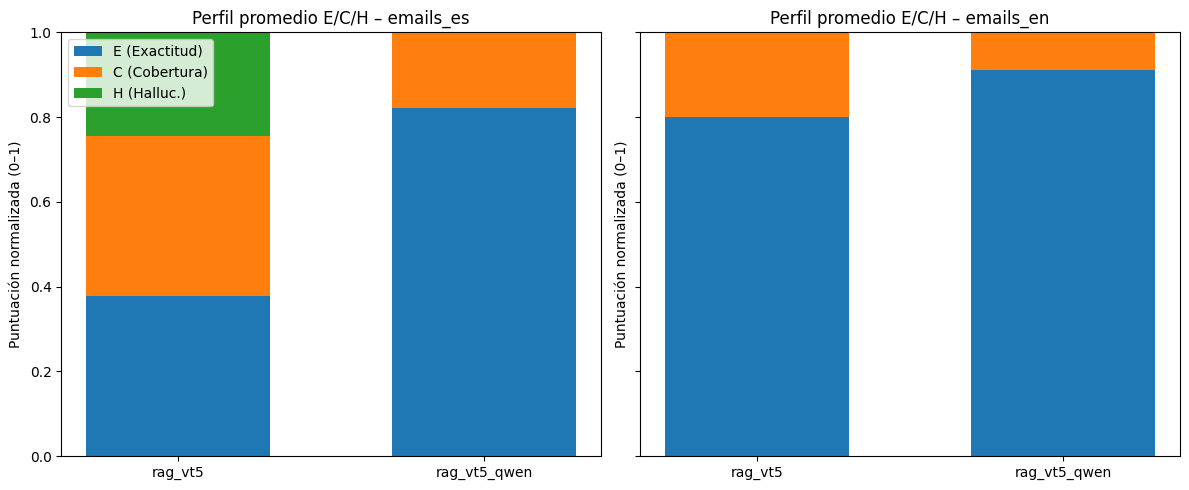

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Cargar la tabla resumen (ajusta el nombre si es distinto)
df = pd.read_csv("multi_eval_summary.csv")

# 2) Normalizar E, C, H a [0,1] (cada uno va de 0 a 3)
df["E_norm"] = df["avg_E"] / 3.0
df["C_norm"] = df["avg_C"] / 3.0
df["H_norm"] = df["avg_H"] / 3.0

datasets = df["dataset"].unique()
n_ds = len(datasets)

fig, axes = plt.subplots(
    1, n_ds,
    figsize=(6 * n_ds, 5),
    sharey=True
)

if n_ds == 1:
    axes = [axes]  # por si solo hubiera 1 dataset

for i, ds in enumerate(datasets):
    ax = axes[i]
    sub = df[df["dataset"] == ds]

    x = np.arange(len(sub))
    width = 0.6

    # Barras apiladas
    ax.bar(x, sub["E_norm"], width, label="E (Exactitud)")
    ax.bar(x, sub["C_norm"], width, bottom=sub["E_norm"], label="C (Cobertura)")
    ax.bar(x, sub["H_norm"], width, bottom=sub["E_norm"] + sub["C_norm"], label="H (Halluc.)")

    ax.set_xticks(x)
    ax.set_xticklabels(sub["experiment"])
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Puntuación normalizada (0–1)")
    ax.set_title(f"Perfil promedio E/C/H – {ds}")

    if i == 0:
        ax.legend(loc="upper left")

plt.tight_layout()
plt.show()


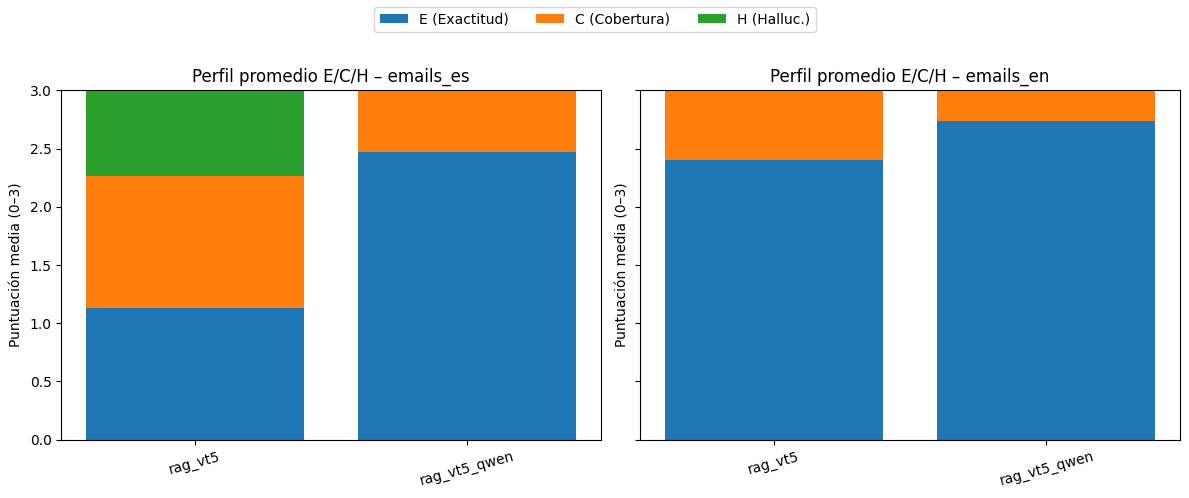

In [26]:
import matplotlib.pyplot as plt

# Asegúrate de que summary_df tenga estas columnas:
# ['dataset', 'experiment', 'avg_E', 'avg_C', 'avg_H']

datasets = summary_df['dataset'].unique()
experiments = summary_df['experiment'].unique()  # para mantener el orden rag_vt5, rag_vt5_qwen

colors = {
    "E": "#1f77b4",   # azul
    "C": "#ff7f0e",   # naranja
    "H": "#2ca02c",   # verde
}

fig, axes = plt.subplots(
    1, len(datasets),
    figsize=(6 * len(datasets), 5),
    sharey=True
)

# por si solo hay un dataset
if len(datasets) == 1:
    axes = [axes]

for ax, ds in zip(axes, datasets):
    # filtramos por dataset y ordenamos por experimento
    sub = (summary_df[summary_df["dataset"] == ds]
           .set_index("experiment")
           .loc[experiments])  # asegura orden rag_vt5 → rag_vt5_qwen

    x = range(len(experiments))
    E = sub["avg_E"]
    C = sub["avg_C"]
    H = sub["avg_H"]

    # barras apiladas con escala real 0–3
    ax.bar(x, E, label="E (Exactitud)", color=colors["E"])
    ax.bar(x, C, bottom=E, label="C (Cobertura)", color=colors["C"])
    ax.bar(x, H, bottom=E + C, label="H (Halluc.)", color=colors["H"])

    ax.set_xticks(list(x))
    ax.set_xticklabels(experiments, rotation=15)
    ax.set_ylim(0, 3)  # escala completa de DUDU (0–3)

    ax.set_ylabel("Puntuación media (0–3)")
    ax.set_title(f"Perfil promedio E/C/H – {ds}")

# leyenda global arriba
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)

fig.tight_layout(rect=(0, 0, 1, 0.9))
plt.show()


En la Figura X se muestra el perfil promedio de los tres componentes de DUDU —E (exactitud semántica), C (cobertura de la información relevante) y H (ausencia de alucinación, es decir, uso correcto del contexto)— para los dos conjuntos de datos y los dos experimentos evaluados.

En el conjunto emails_es, el modelo base rag_vt5 presenta valores medios cercanos a 1 en E y C, y alrededor de 1.3 en H (en una escala de 0 a 3). Esto indica que, desde la perspectiva del juez LLM, muchas respuestas en español son sólo parcialmente correctas, cubren de forma limitada la información clave y muestran un grado apreciable de alucinación o uso débil del contexto recuperado. Al incorporar la capa generativa de Qwen (rag_vt5_qwen), los tres componentes aumentan de forma clara hasta valores cercanos a 2.5–2.8. En términos prácticos, esto significa que las respuestas pasan a ser, en promedio, “mayormente correctas y completas”, y mucho mejor fundamentadas en el contexto, reduciendo notablemente los casos de alucinación. Esta ganancia coincide con el fuerte incremento del DUDU_score global observado para este dataset.

En el conjunto emails_en, el comportamiento es distinto: el modelo base rag_vt5 ya parte de valores altos en E, C y H (≈2.3–2.8), lo que indica un desempeño sólido en inglés. La variante rag_vt5_qwen mantiene este buen nivel y lo mejora ligeramente, elevando los tres componentes hacia valores próximos al máximo de la escala. Desde la perspectiva del esquema DUDU, esto sugiere que, en inglés, Qwen actúa más como un refinamiento que como una corrección profunda: las respuestas ya eran mayoritariamente correctas y bien fundamentadas, y la integración de Qwen las hace todavía más precisas y completas, pero con un margen de mejora menor que en el caso del español, donde sí corrige deficiencias importantes del modelo base.